# protocol for unsupervised sample selection

--- Get the data from where to select the samples. Note that here we have availability of Y values and test sets but in a real application, only **x_initial** is available

In [1]:
# --------------------------------------------------------------------------

# ----------------- for external use: protocol for  unsupervised sample selection

# -------------------------------------------------------------------------


# ¡¡¡ --- !!! # ---> modules and data cases

# --- system modules

import sys
import datetime
import os


base_dir = os.path.abspath(os.getcwd() + "/..")

# --- data handling modules

import numpy as np
import pandas as pd
import scipy.io as sp_io
import scipy as sp

# --- visualization modules

import matplotlib.pyplot as plt
import matplotlib as mtply

# --- my modules

methods_dir = base_dir + '/methods/'  
sys.path.insert(0, methods_dir)
from class_sample_selection import sample_selection
import simpls_module



# ¡¡¡ --- !!! # ---> base working directory and available data cases

# # ************************************ init --- user 
caseID_key = "d01_milk"
y_id = 2 # lactose
# # ************************************ end --- user 



# # ¡¡¡ --- !!! # ---> data

mat_filename = base_dir + "/data/" + caseID_key +".mat"
data_mat = sp_io.loadmat(mat_filename, struct_as_record = False)



x_initial = data_mat["xcal"].copy()
y_initial = data_mat["ycal"].copy()[:,[y_id]]
xtest = data_mat["xtest"].copy()
ytest = data_mat["ytest"].copy()[:,[y_id]]
chemical_comp_name = data_mat["y_labels"][y_id]

print("--- data ready ---")





--- data ready ---


--- Outliers can be removed prior to sample selection if needed

[0.99 0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]


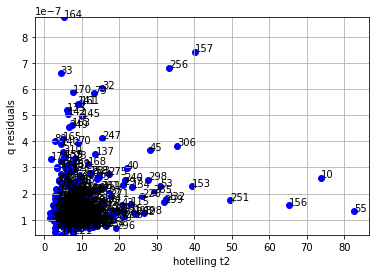

In [2]:
# initial pca for exploratory analysis


pca_mu = x_initial.mean(axis=0)

X_c = x_initial - pca_mu
X_c_t = np.ascontiguousarray(X_c.transpose())
cov_X = X_c_t.dot(X_c)/X_c.shape[0]
svd_cov_X = np.linalg.svd(cov_X)


chosen_pc = 10

pc_loadings = svd_cov_X[0][:,0:chosen_pc]
tscores = (x_initial - pca_mu).dot(pc_loadings)
x_all_predicted = tscores.dot(pc_loadings.T) + pca_mu

q_residuals = np.mean(np.power(x_initial - x_all_predicted,2),axis=1)
hotelling_t2 = np.diag(tscores.dot(np.diag(1/svd_cov_X[1][0:chosen_pc])).dot(tscores.T))

print(np.round(svd_cov_X[1]/np.sum(svd_cov_X[1]),2)[0:chosen_pc])

plt.scatter(hotelling_t2,q_residuals,c="blue")
for ii in range(hotelling_t2.shape[0]):
    plt.text(hotelling_t2[ii],q_residuals[ii], str(ii))
plt.grid()
plt.ylim(np.amin(q_residuals),np.amax(q_residuals))
plt.xlabel("hotelling t2")
plt.ylabel("q residuals")
plt.show()



In [4]:
# --- observations to carry for unsupervised sample selection

drop_obs = [] # input here the outliers id's

x_all = np.delete(x_initial, obj = drop_obs, axis=0)
y_all = np.delete(y_initial, obj = drop_obs, axis=0)

print("done")
x_all.shape

done


(316, 256)

--- Parameters for unsupervised sample selection

In [7]:
# --- optimal complexity

d = 16 # number of lv
n_sel = 12*d+1
a = d + 5 # number of pc 

--- Methods for sample selection

In [8]:
# --- select samples

dim_red = True
dist_measure = "mahalanobis"

my_sample_selection = sample_selection(x_all, ncp = a)  
my_sample_selection.get_xcal_pca_scores(first_ncp = 0)

selected_sets = {}

selected_sets["random_sample"] = my_sample_selection.random_sample(Nout = n_sel)["sample_id"][:,0]

selected_sets["ks_sample"] = my_sample_selection.kennard_stone(Nout = n_sel, fixed_samples=None, dim_reduction=dim_red, distance_measure=dist_measure)["sample_id"][:,0]

selected_sets["duplex_sample"] = my_sample_selection.duplex(Nout = n_sel, dim_reduction=dim_red, distance_measure=dist_measure)["sample_id"][:,0]

selected_sets["puch_sample"] = my_sample_selection.puchwein(Nout = n_sel, factor_k=0.0001, dim_reduction=dim_red, distance_measure=dist_measure)["sample_id"][:,0]

selected_sets["clus_sample"] = my_sample_selection.clustering(Nout = n_sel , dim_reduction=dim_red, distance_measure=dist_measure)["sample_id"][:,0]

selected_sets["doe_sample"] = my_sample_selection.optfederov_r(Nout = n_sel, fixed_samples=None, optimality_criterion='D')["sample_id"][:,0]

print("done")

done


In [9]:
# --- select one sample set for cal

method_name = "doe_sample"
selected_cal_set = selected_sets[method_name].copy()


--- Evaluation of one set of selected samples

In [10]:
# --- evaluate selected cal set: S matrix eigen decomp


X_c = x_all - x_all.mean(axis=0)
X_c_t = np.ascontiguousarray(X_c.transpose())
cov_X = X_c_t.dot(X_c)/X_c.shape[0]
svd_cov_X = np.linalg.svd(cov_X)

x_selected = x_all[selected_cal_set==1,:]
Xs_c = x_selected - x_selected.mean(axis=0)
Xs_c_t = np.ascontiguousarray(Xs_c.transpose())
cov_Xs = Xs_c_t.dot(Xs_c)/Xs_c.shape[0]
svd_selected = np.linalg.svd(cov_Xs)

eigen_vals_ratio = svd_selected[1][0:a]/svd_cov_X[1][0:a]
eigen_vect_comparison = svd_selected[0][:,0:a].T.dot(svd_cov_X[0][:,0:a])

eigen_vect_criterion = np.abs(np.linalg.det(eigen_vect_comparison))

print("determinant eigenvectors: ",eigen_vect_criterion)

determinant eigenvectors:  0.9568899346579494


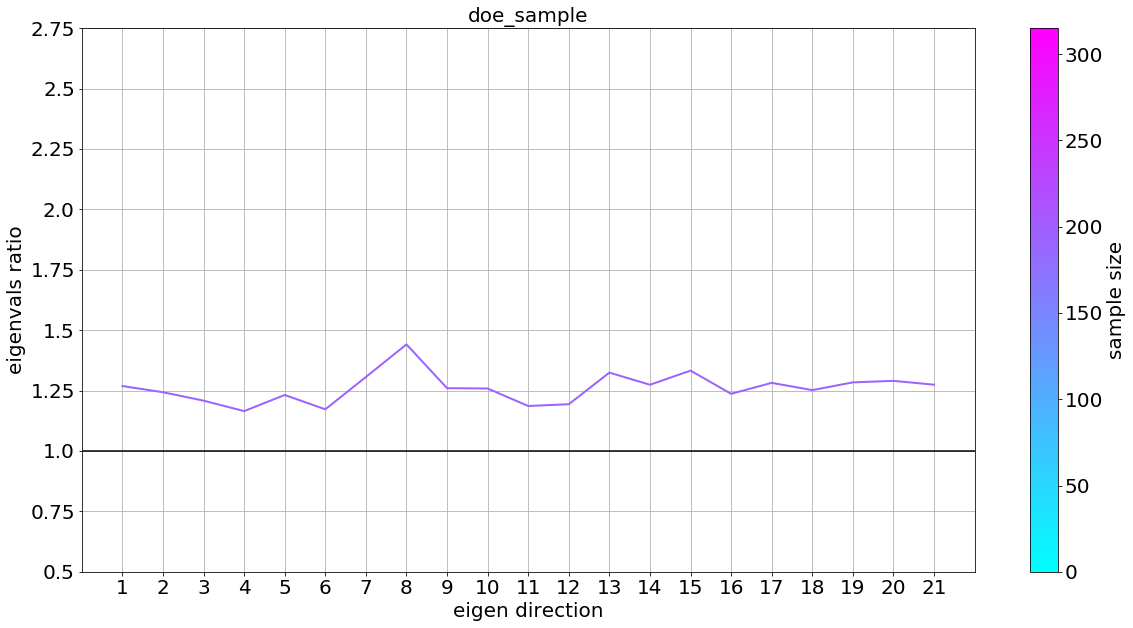

In [11]:
# --- plot eigenvals ratio

color_var = np.arange(x_all.shape[0])
min_color_var = np.amin(color_var)
max_color_var = np.amax(color_var)

c_m = mtply.cm.cool
norm = mtply.colors.Normalize(vmin = min_color_var, vmax = max_color_var)
s_m = mtply.cm.ScalarMappable(cmap = c_m, norm = norm)

font_size = 20
yticks = np.arange(0.5,3, 0.25)
xticks = np.arange(1,a+1)


fig, ax = plt.subplots(figsize = (20,10))
color_tuple = s_m.to_rgba(n_sel)

ax.plot(xticks,eigen_vals_ratio, c = color_tuple, Linewidth = 2)
ax.grid()

ax.set_title(method_name, fontsize = font_size)

ax.set_xlabel("eigen direction", fontsize = font_size)
ax.set_xticks(xticks)
ax.set_xticklabels(labels = xticks, fontsize = font_size)

ax.set_ylabel("eigenvals ratio", fontsize = font_size)
ax.set_yticks(yticks)
ax.set_yticklabels(labels = yticks, fontsize = font_size)
ax.axhline(y=1, c = "black")


cbar = plt.colorbar(s_m)
cbar.set_label("sample size", fontsize = font_size)
cbar.ax.tick_params(labelsize=font_size)

plt.show()

--- In this example there are Y values and test set, so we check how the pls model results

In [12]:
# model data

xcal = x_all[selected_cal_set==1,:]
ycal = y_all[selected_cal_set==1,:]

print(xcal.shape, xtest.shape)
print(ycal.shape, ytest.shape)


(193, 256) (79, 256)
(193, 1) (79, 1)


In [13]:
# --- calibrate model with cal data 

total_lv = 20

output_pls = simpls_module.simpls_fit(xx=xcal, yy=ycal, ncp=total_lv)
cv_output = simpls_module.simpls_univariate_cv(xx=xcal, yy=ycal, total_ncp=total_lv, number_splits=10)
ycal_pred = simpls_module.simpls_predict(xcal,  output_pls[0],output_pls[1],output_pls[2])

ytest_pred = simpls_module.simpls_predict(xtest,  output_pls[0],output_pls[1],output_pls[2])
rmsep = simpls_module.rmse(ytest, ytest_pred, np.ones(ytest_pred.shape[0]))
r2p = simpls_module.r2(ytest, ytest_pred, np.ones(ytest_pred.shape[0]))


print("done")

done


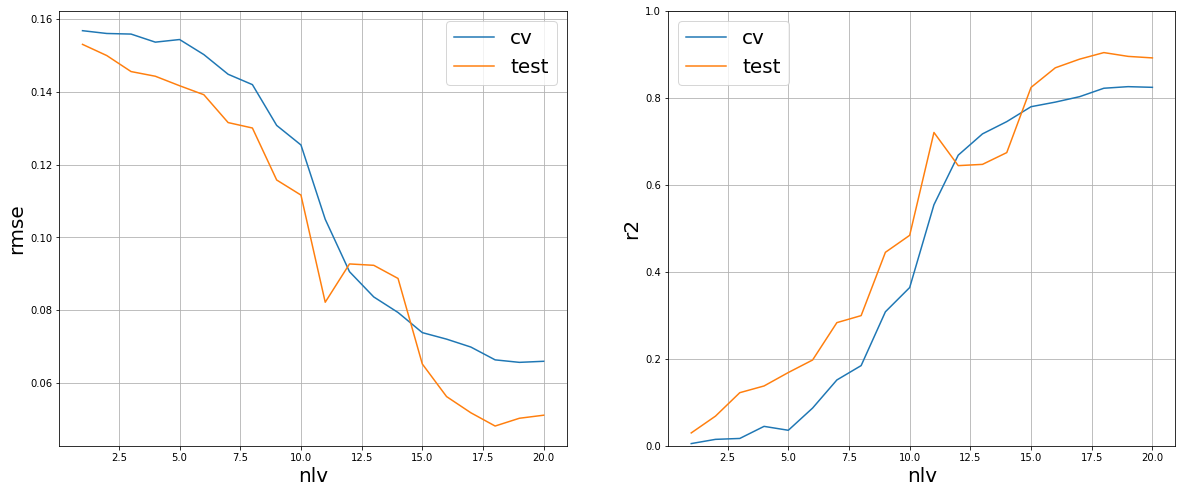

In [14]:
# --- check performance

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))


# --- visualize performance cv

ax[0].plot(np.arange(1, total_lv+1),cv_output[0], label = "cv")
ax[0].set_xlabel("nlv", fontsize = font_size)
ax[0].set_ylabel("rmse", fontsize = font_size)
ax[0].grid()


ax[1].plot(np.arange(1, total_lv+1),cv_output[1], label = "cv") 
ax[1].set_xlabel("nlv", fontsize = font_size)
ax[1].set_ylabel("r2", fontsize = font_size)
ax[1].set_ylim([0,1])     
ax[1].grid()


# --- visualize performance test

ax[0].plot(np.arange(1, total_lv+1),rmsep, label = "test" )   
ax[1].plot(np.arange(1, total_lv+1),r2p, label = "test" )


ax[0].legend(fontsize = font_size)
ax[1].legend(fontsize = font_size)

    
plt.show()

--- Summary calibration model--- 

lv: 17
rmsep: 0.052
r2p: 0.889
rmsecv: 0.07
r2cv: 0.803


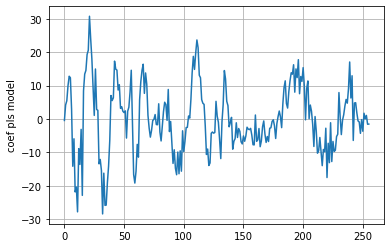

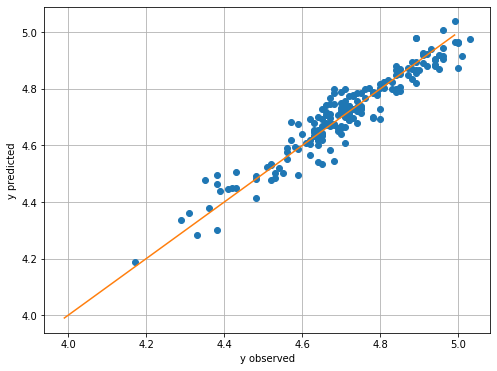

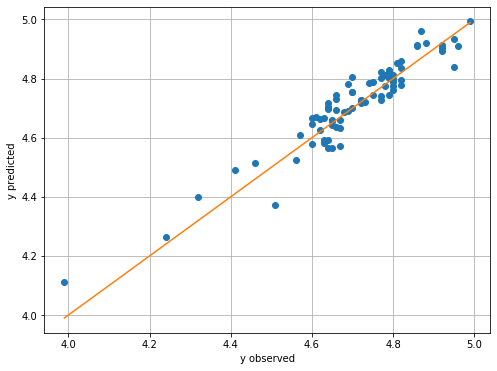

In [15]:
# --- error on test and scores

# *************************
chosen_lv = 17
# *************************


# predicted vs observed

info_model = "lv: " + str(chosen_lv) + "\n" + "rmsep: " + str(np.round(rmsep[chosen_lv-1,0],3)) + "\n" +"r2p: "+str(np.round(r2p[chosen_lv-1,0],3)) +"\n" + "rmsecv: " + str(np.round(cv_output[0][chosen_lv-1],3))+ "\n" +"r2cv: " + str(np.round(cv_output[1][chosen_lv-1],3))

print("--- Summary calibration model--- \n")
print(info_model)


plt.plot(output_pls[0][:,chosen_lv-1,:])
plt.grid()
plt.ylabel("coef pls model")
plt.show()

plt.subplots(figsize = (8,6))
plt.plot(ycal[:,0],ycal_pred[:,chosen_lv-1,0],'o')
plt.plot([np.amin(ytest),np.amax(ytest)],[np.amin(ytest),np.amax(ytest)])
plt.grid()
plt.xlabel("y observed")
plt.ylabel("y predicted")
plt.show()

plt.subplots(figsize = (8,6))
plt.plot(ytest[:,0],ytest_pred[:,chosen_lv-1,0],'o')
plt.plot([np.amin(ytest),np.amax(ytest)],[np.amin(ytest),np.amax(ytest)])
plt.grid()
plt.xlabel("y observed")
plt.ylabel("y predicted")
plt.show()


